# **1. SET-UP**

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/sample_data/MyDrive')

Mounted at /content/sample_data/MyDrive


In [3]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import cv2
import numpy as np
from tensorflow import keras

In [ ]:
!pip install scipy==1.1.0

# **2. DATA PRE-PROCESSING**

In [4]:
data_dir = ('/content/sample_data/MyDrive/MyDrive/lane_detection/data_road/training')

Text(0.5, 1.0, 'Label')

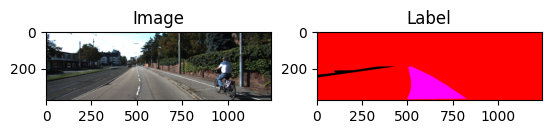

In [5]:
img = cv2.imread("/content/sample_data/MyDrive/MyDrive/lane_detection/data_road/training/image_2/um_000000.png")
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Image")

label = cv2.imread("/content/sample_data/MyDrive/MyDrive/lane_detection/data_road/training/gt_image_2/um_lane_000000.png")
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(label, cv2.COLOR_BGR2RGB))
plt.title("Label")

In [6]:
images_folder = ("/content/sample_data/MyDrive/MyDrive/lane_detection/data_road/training/image_2")
ground_truth_folder = ("/content/sample_data/MyDrive/MyDrive/lane_detection/data_road/training/gt_image_2")

In [7]:
import os
import re

def alphanumeric_key(s):
    # Split the string into a list of strings and numbers
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]


train_images = []
labels = []

# Load images
image_files = sorted([file for file in os.listdir(images_folder) if file.endswith('.png')], key=alphanumeric_key)
for image_file in image_files:
    image_path = os.path.join(images_folder, image_file)
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (160, 80))  # Specify the desired dimensions
    train_images.append(resized_image)

# Load ground truth
ground_truth_files = sorted([file for file in os.listdir(ground_truth_folder) if file.endswith('.png')], key=alphanumeric_key)
for ground_truth_file in ground_truth_files:
    ground_truth_path = os.path.join(ground_truth_folder, ground_truth_file)
    ground_truth = cv2.imread(ground_truth_path)#, cv2.IMREAD_GRAYSCALE)
    resized_ground_truth = cv2.resize(ground_truth, (160, 80))  # Specify the desired dimensions
    labels.append(resized_ground_truth)



# Convert lists to NumPy arrays
train_images = np.array(train_images)
labels = np.array(labels)

# Print the shapes of the arrays
print("train_images shape:", train_images.shape)
print("labels shape:", labels.shape)



train_images shape: (193, 80, 160, 3)
labels shape: (193, 80, 160, 3)


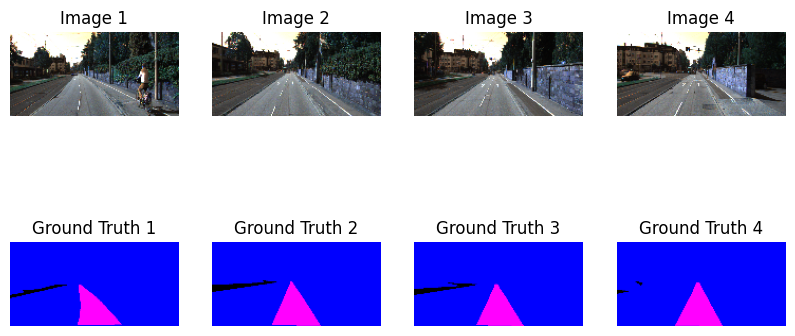

In [ ]:
from PIL import Image as im
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(2, 4, i+1)
    data = im.fromarray(train_images[i])
    plt.imshow(data)
    plt.title('Image {}'.format(i+1))
    plt.axis('off')

    plt.subplot(2, 4, i+5)
    data2 = im.fromarray(labels[i])
    plt.imshow(data2)
    plt.title('Ground Truth {}'.format(i+1))
    plt.axis('off')

plt.show()

# **3. DATA PRE-PROCESSING**

In [8]:
train_images[0].max()

255

In [9]:
labels[0].max()

255

In [10]:
scaled_labels = labels/255

In [11]:
scaled_labels[0].max()
scaled_labels.shape

(193, 80, 160, 3)

In [12]:
from sklearn.utils import shuffle

X, Y = shuffle(train_images, scaled_labels, random_state=100)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=.1, random_state=100)
print("The training set is : ", X_train.shape, X_val.shape)
print("The testing set is :", Y_train.shape, Y_val.shape)

The training set is :  (173, 80, 160, 3) (20, 80, 160, 3)
The testing set is : (173, 80, 160, 3) (20, 80, 160, 3)


In [14]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(channel_shift_range=0.2)
train_datagen.fit(X_train)

In [15]:
batch_size = 64
epochs = 30
pool_size = (2, 2)
input_shape = X_train.shape[1:]

# **4. SEG NET**

In [ ]:
# segnet
model=tf.keras.models.Sequential([
# Normalizes incoming inputs. First layer needs the input shape to work
tf.keras.layers.BatchNormalization(input_shape=input_shape),
tf.keras.layers.Conv2D(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv1'),
tf.keras.layers.Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv2'),
# Pooling 1
tf.keras.layers.MaxPooling2D(pool_size=pool_size),

tf.keras.layers.Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv3'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv4'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv5'),
tf.keras.layers.Dropout(0.2),
 # Pooling 2
tf.keras.layers.MaxPooling2D(pool_size=pool_size),

tf.keras.layers.Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv6'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv7'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv8'),
# Pooling 3
tf.keras.layers.MaxPooling2D(pool_size=pool_size),
# Upsample 1
tf.keras.layers.UpSampling2D(size=pool_size),
#Deconv
tf.keras.layers.Conv2DTranspose(128, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv1'),
tf.keras.layers.Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv2'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv3'),
tf.keras.layers.Dropout(0.25),
# Upsample 2
tf.keras.layers.UpSampling2D(size=pool_size),

tf.keras.layers.Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv4'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv5'),
# Upsample 3
tf.keras.layers.UpSampling2D(size=pool_size),

tf.keras.layers.Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv6'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv7'),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv8'),
tf.keras.layers.Conv2DTranspose(1, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv9Finalone')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 160, 80, 3)        12        
 Normalization)                                                  
                                                                 
 Conv1 (Conv2D)              (None, 158, 78, 8)        224       
                                                                 
 Conv2 (Conv2D)              (None, 156, 76, 16)       1168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 78, 38, 16)        0         
 D)                                                              
                                                                 
 Conv3 (Conv2D)              (None, 76, 36, 16)        2320      
                                                                 
 dropout (Dropout)           (None, 76, 36, 16)        0

In [ ]:
# Compiling and training the model
model.compile(optimizer='Adam', loss='mean_squared_error',metrics=['accuracy'])

model.fit(train_datagen.flow(X_train, Y_train, batch_size=batch_size),
                steps_per_epoch=len(X_train)/batch_size,
                epochs=epochs, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/30
2/2 [==============================] - 29s 6s/step - loss: 0.3543 - accuracy: 0.6240 - val_loss: 0.3186 - val_accuracy: 0.6302
Epoch 2/30
2/2 [==============================] - 1s 166ms/step - loss: 0.3346 - accuracy: 0.6334 - val_loss: 0.2857 - val_accuracy: 0.6302
Epoch 3/30
2/2 [==============================] - 0s 169ms/step - loss: 0.3003 - accuracy: 0.6017 - val_loss: 0.2687 - val_accuracy: 0.6019
Epoch 4/30
2/2 [==============================] - 1s 185ms/step - loss: 0.2793 - accuracy: 0.6321 - val_loss: 0.2725 - val_accuracy: 0.6302
Epoch 5/30
2/2 [==============================] - 1s 190ms/step - loss: 0.2666 - accuracy: 0.6323 - val_loss: 0.2648 - val_accuracy: 0.5542
Epoch 6/30
2/2 [==============================] - 1s 240ms/step - loss: 0.2536 - accuracy: 0.5936 - val_loss: 0.2454 - val_accuracy: 0.6302
Epoch 7/30
2/2 [==============================] - 1s 178ms/step - loss: 0.2445 - accuracy: 0.6321 - val_loss: 0.2428 - val_accuracy: 0.6302
Epoch 8/30
2/2 [======

In [ ]:
preds = model.predict(X_val)
preds.max(), preds.min()

1/1 [==============================] - 0s 387ms/step


(0.6109767, 0.03317913)

In [ ]:
import tensorflow as tf
import numpy as np

# Example prediction tensor (replace this with actual predictions)
preds = np.random.rand(20, 160, 80, 1)  # Simulated prediction data

# Replicate the single channel predictions to create three channels
preds_three_channel = np.repeat(preds, 3, axis=-1)

# Initialize metrics
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])

# Update metrics
accuracy.update_state(Y_val, preds_three_channel)
accuracy_value = accuracy.result().numpy()

precision.update_state(Y_val, preds_three_channel)
precision_value = precision.result().numpy()

recall.update_state(Y_val, preds_three_channel)
recall_value = recall.result().numpy()

# F1 score
f1_score = 2 / ((1 / precision_value) + (1 / recall_value))

# Intersection over Union (IoU)
iou.update_state(Y_val, preds_three_channel)
iou_value = iou.result().numpy()

print("Accuracy:", accuracy_value)
print("Precision:", precision_value)
print("Recall:", recall_value)
print('F1 Score:', f1_score)
print('IoU:', iou_value)


Accuracy: 0.0
Precision: 0.3698303
Recall: 0.4996092
F1 Score: 0.42503388361425964
IoU: 0.0


# **5. FCN**

In [ ]:
#fcn
import tensorflow as tf
from keras.layers import Input, Conv2DTranspose, Conv2D
from keras.applications.resnet50 import ResNet50

# Define the input shape of the images
input_shape = (160, 80, 3)

# Define the encoder using a pretrained ResNet50 model
encoder = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Find the index of the layer named 'conv3_block4_out' (output size 32x32xnC)
for i, layer in enumerate(encoder.layers):
    if layer.name == 'conv3_block4_out':
        break

# Create a new model that includes only the layers up to 'conv3_block4_out'
encoder = tf.keras.Model(inputs=encoder.inputs, outputs=encoder.layers[i].output)

# Freeze the weights of the encoder layers to prevent them from being updated during training
for layer in encoder.layers[:50]:
    layer.trainable = False

# Define the decoder using a smaller FCN architecture
def decoder(inputs):
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(inputs)
    up1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    up2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(up3)
    return outputs

# Define the input tensor
inputs = Input(input_shape)

# Pass the input through the encoder and decoder to obtain the output
encoded = encoder(inputs)
outputs = decoder(encoded)

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)



94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss=keras.losses.BinaryFocalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 80, 3)]      0         
                                                                 
 model (Functional)          (None, 20, 10, 512)       1460096   
                                                                 
 conv2d (Conv2D)             (None, 20, 10, 256)       1179904   
                                                                 
 conv2d_transpose (Conv2DTr  (None, 40, 20, 256)       262400    
 anspose)                                                        
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 20, 128)       295040    
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 80, 40, 128)       65664     
 Transpose)                                                

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

# Define the folder path to save TensorBoard logs
tensorboard_logs_folder = '/content/sample_data/MyDrive/MyDrive/lane_detection/logs'

# Create the folder if it doesn't exist
os.makedirs(tensorboard_logs_folder, exist_ok=True)

# Define the TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=tensorboard_logs_folder, histogram_freq=1)

In [ ]:
# Define TensorBoard callback
tensorboard_callback = keras.callbacks.TensorBoard(log_dir='/content/sample_data/MyDrive/MyDrive/lane_detection/logs', histogram_freq=1)

# Define ModelCheckpoint callback
model_checkpoint_callback =  keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")


# Combine all callbacks
callbacks = [tensorboard_callback, model_checkpoint_callback]

In [ ]:
# create metrics
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])

history = model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    callbacks=[tensorboard_callback] + callbacks,
    validation_data=(X_val, Y_val),
    batch_size=batch_size
)

Epoch 1/30
3/3 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.6525

  saving_api.save_model(



3/3 [==============================] - 35s 7s/step - loss: 0.1273 - accuracy: 0.6525 - val_loss: 0.0547 - val_accuracy: 0.8841
Epoch 2/30
3/3 [==============================] - 4s 2s/step - loss: 0.0523 - accuracy: 0.8805 - val_loss: 0.0402 - val_accuracy: 0.8841
Epoch 3/30
3/3 [==============================] - 4s 2s/step - loss: 0.0319 - accuracy: 0.8834 - val_loss: 0.0715 - val_accuracy: 0.8841
Epoch 4/30
3/3 [==============================] - 4s 2s/step - loss: 0.0264 - accuracy: 0.8834 - val_loss: 0.0878 - val_accuracy: 0.8841
Epoch 5/30
3/3 [==============================] - 4s 2s/step - loss: 0.0242 - accuracy: 0.8834 - val_loss: 0.1332 - val_accuracy: 0.8841
Epoch 6/30
3/3 [==============================] - 4s 2s/step - loss: 0.0223 - accuracy: 0.8834 - val_loss: 0.1576 - val_accuracy: 0.8841
Epoch 7/30
3/3 [==============================] - 4s 2s/step - loss: 0.0207 - accuracy: 0.8834 - val_loss: 0.1312 - val_accuracy: 0.8841
Epoch 8/30
3/3 [==============================] - 5

In [ ]:
preds = model.predict(X_val)
preds.max(), preds.min()

1/1 [==============================] - 0s 21ms/step


(1.0, 0.0)

In [ ]:
import tensorflow as tf
import numpy as np

# Example prediction tensor (replace this with actual predictions)
preds = np.random.rand(20, 160, 80, 1)  # Simulated prediction data

# Replicate the single channel predictions to create three channels
preds_three_channel = np.repeat(preds, 3, axis=-1)

# Initialize metrics
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])

# Update metrics
accuracy.update_state(Y_val, preds_three_channel)
accuracy_value = accuracy.result().numpy()

precision.update_state(Y_val, preds_three_channel)
precision_value = precision.result().numpy()

recall.update_state(Y_val, preds_three_channel)
recall_value = recall.result().numpy()

# F1 score
f1_score = 2 / ((1 / precision_value) + (1 / recall_value))

# Intersection over Union (IoU)
iou.update_state(Y_val, preds_three_channel)
iou_value = iou.result().numpy()

print("Accuracy:", accuracy_value)
print("Precision:", precision_value)
print("Recall:", recall_value)
print('F1 Score:', f1_score)
print('IoU:', iou_value)


Accuracy: 0.0
Precision: 0.36962137
Recall: 0.5003732
F1 Score: 0.425171904725855
IoU: 0.0


In [ ]:
Y_train.shape

(173, 160, 80, 3)

1/1 [==============================] - 2s 2s/step


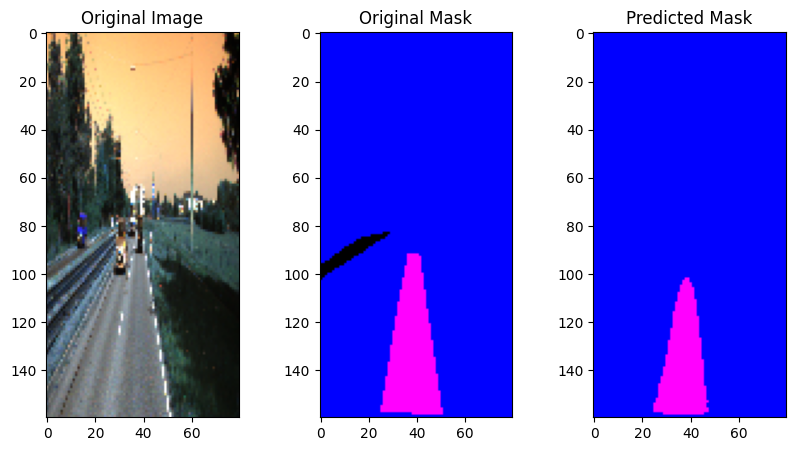

1/1 [==============================] - 0s 43ms/step


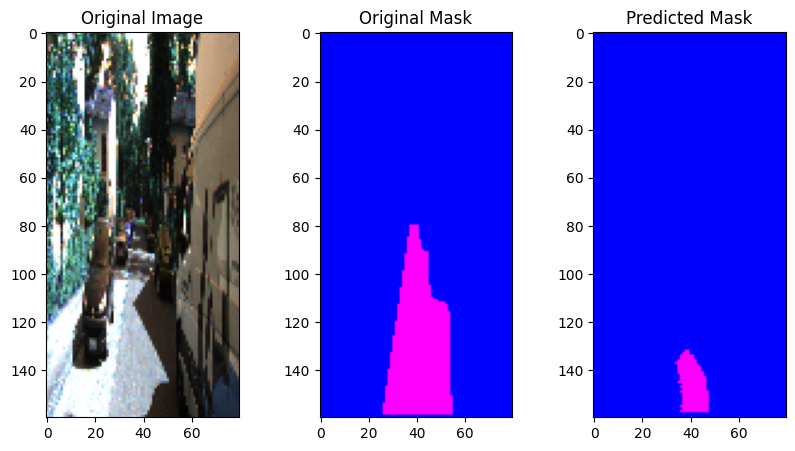

1/1 [==============================] - 0s 22ms/step


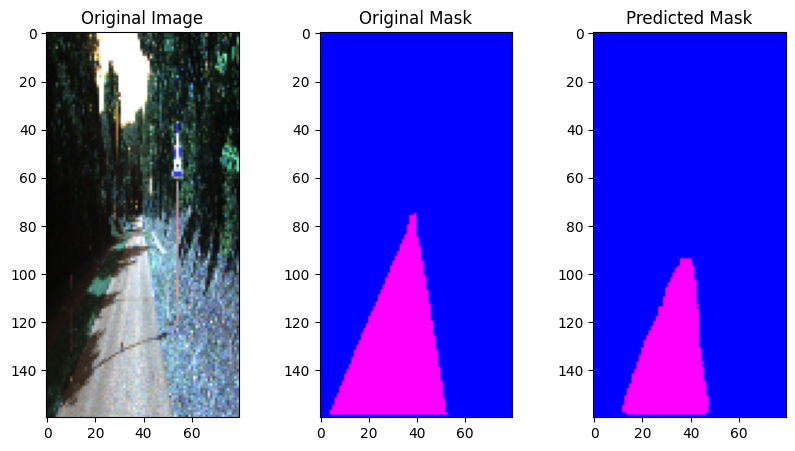

1/1 [==============================] - 0s 31ms/step


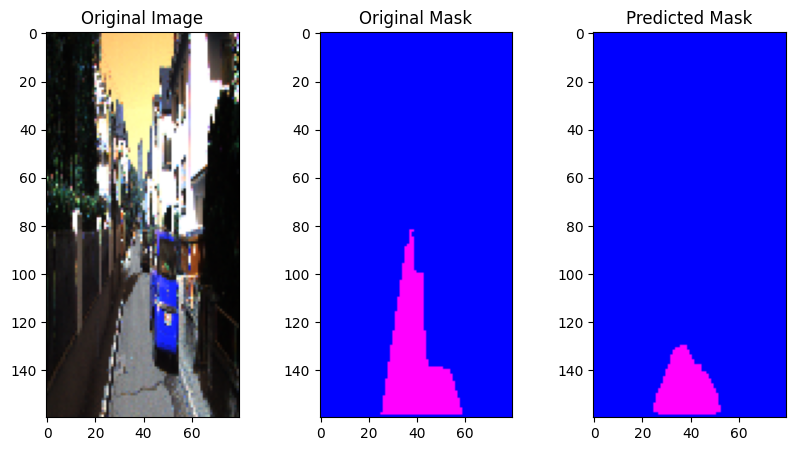

1/1 [==============================] - 0s 19ms/step


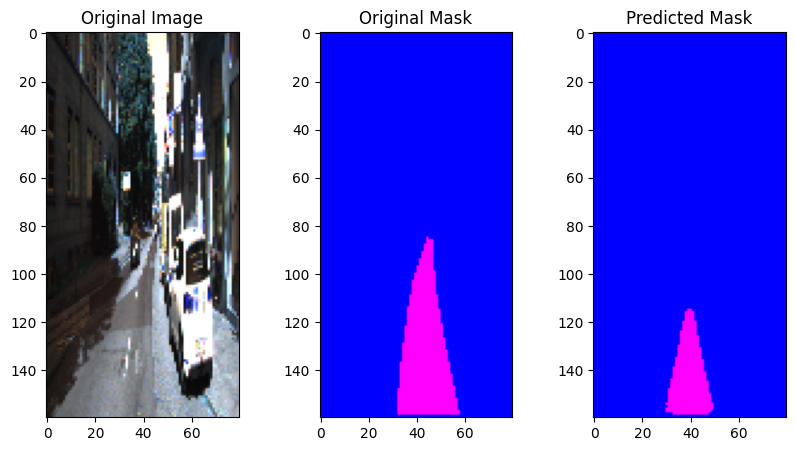

1/1 [==============================] - 0s 28ms/step


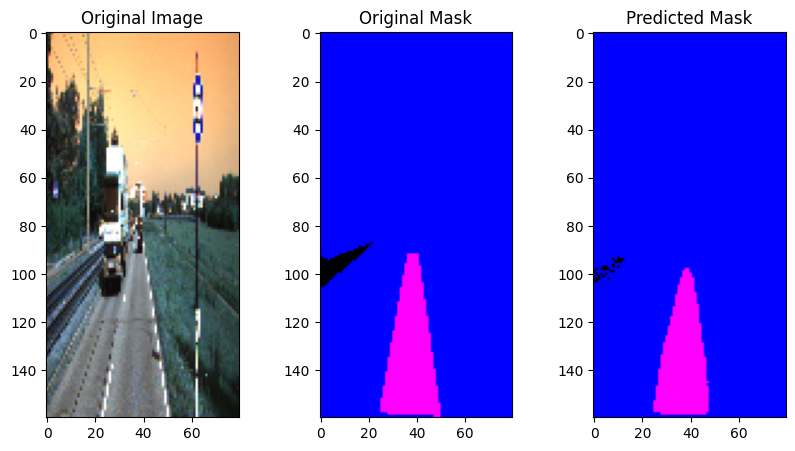

1/1 [==============================] - 0s 29ms/step


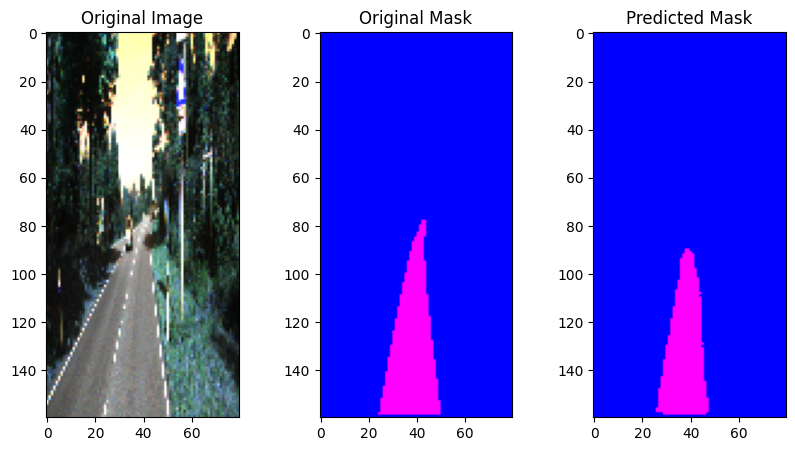

1/1 [==============================] - 0s 32ms/step


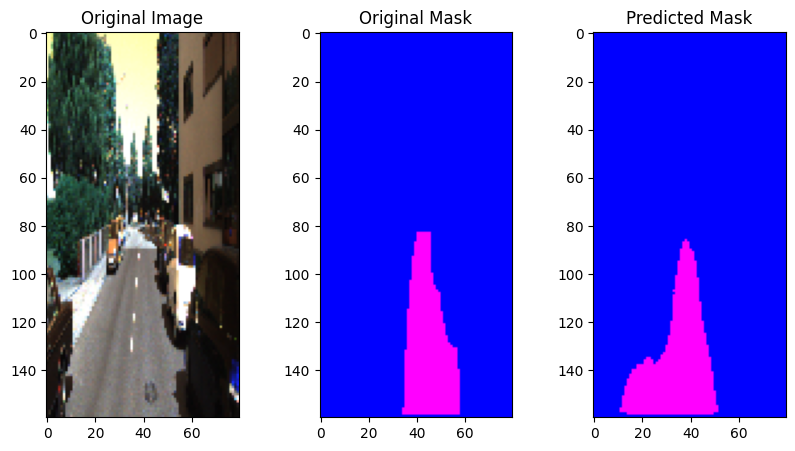

1/1 [==============================] - 0s 36ms/step


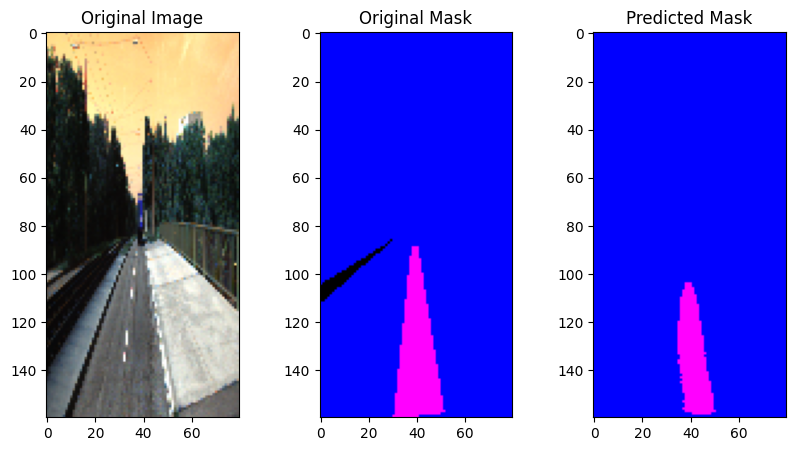

1/1 [==============================] - 0s 40ms/step


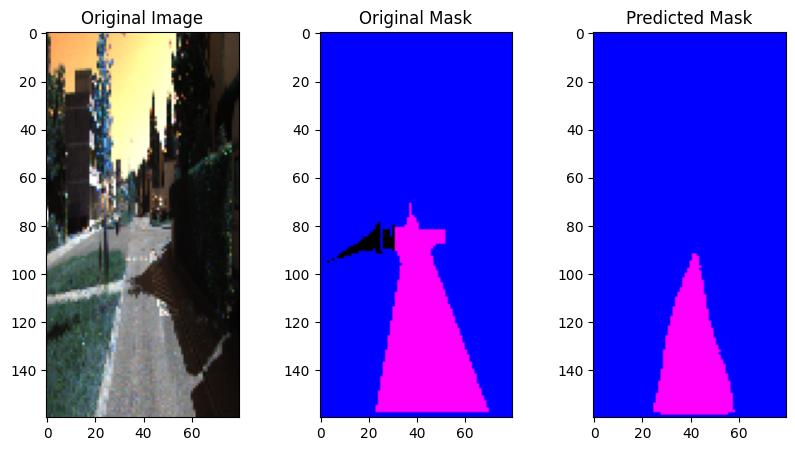

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_val is a list or array containing image data
# Modify this according to the actual structure of your data

# Function to preprocess and predict using the model
def predict_and_show(image_data, original_mask, model):
    # Preprocess the image data
    test_array = np.array(image_data)

    # Predict using the model
    yhat = model.predict(np.expand_dims(test_array, 0))
    yhat = np.round(yhat.squeeze())  # Remove singleton dimensions and round to 0 or 1

    # Create a mask image using PIL
    mask_image = Image.fromarray((yhat * 255).astype(np.uint8))

    # Display the original image and predicted mask side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image_data)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(original_mask*255)
    plt.title("Original Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(np.array(yhat*255).astype(np.uint8))  # Specify the colormap if it's a grayscale image
    plt.title("Predicted Mask")

    plt.show()

# Assuming X_val contains the image data for validation
for i in range(10):
    image_data = X_val[i]
    original_mask = Y_val[i]
    predict_and_show(image_data,original_mask, model)


In [ ]:
test_dir = "/content/sample_data/MyDrive/MyDrive/lane_detection/data_road/testing/image_2"
import os
import re

def alphanumeric_key(s):
    # Split the string into a list of strings and numbers
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]


test_images = []

# Load images
image_files = sorted([file for file in os.listdir(test_dir) if file.endswith('.png')], key=alphanumeric_key)
for image_file in image_files:
    image_path = os.path.join(test_dir, image_file)
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (80,160))  # Specify the desired dimensions
    test_images.append(resized_image)


# Convert lists to NumPy arrays
test_images = np.array(test_images)

# Print the shapes of the arrays
print("test_images shape:", test_images.shape)

test_images shape: (290, 160, 80, 3)


1/1 [==============================] - 0s 67ms/step


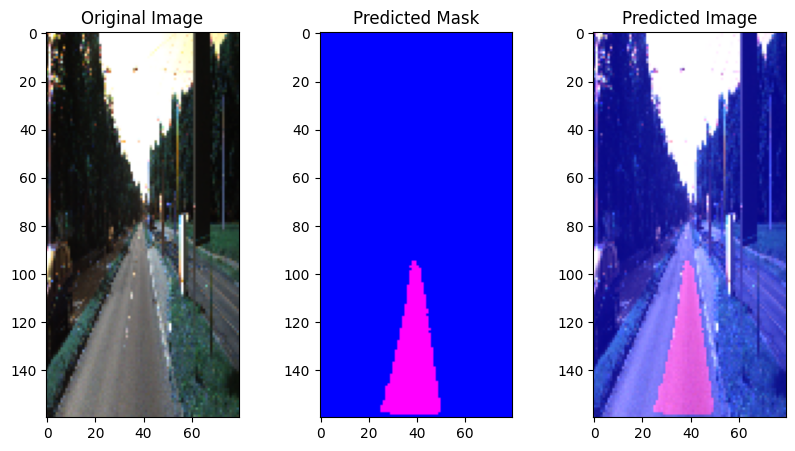

1/1 [==============================] - 0s 37ms/step


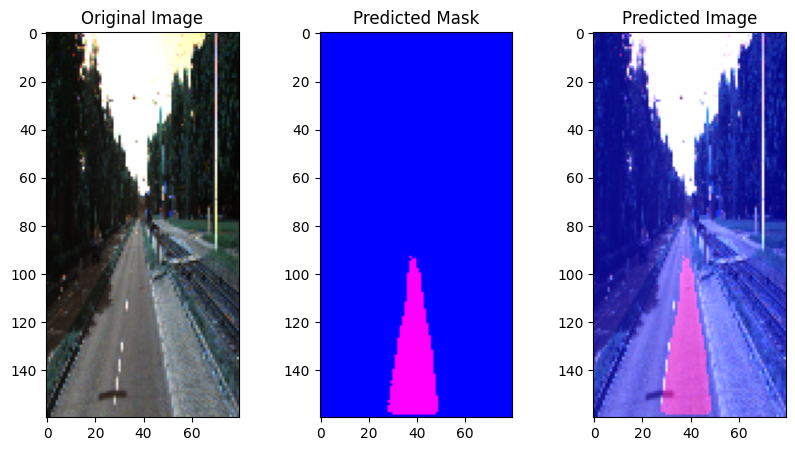

1/1 [==============================] - 0s 31ms/step


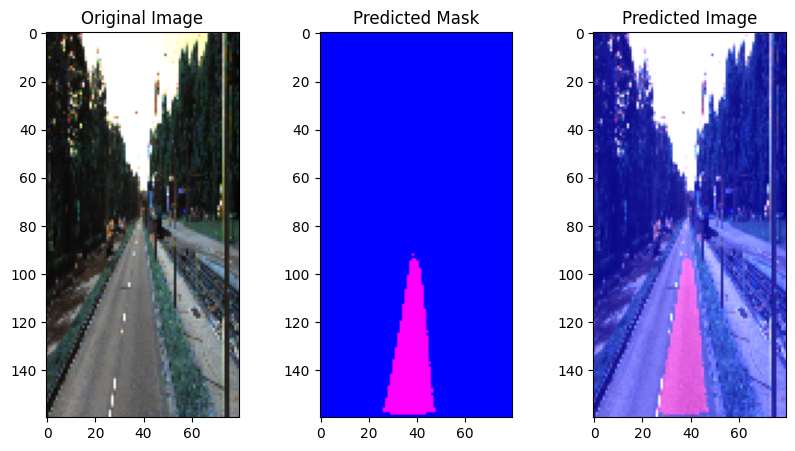

1/1 [==============================] - 0s 22ms/step


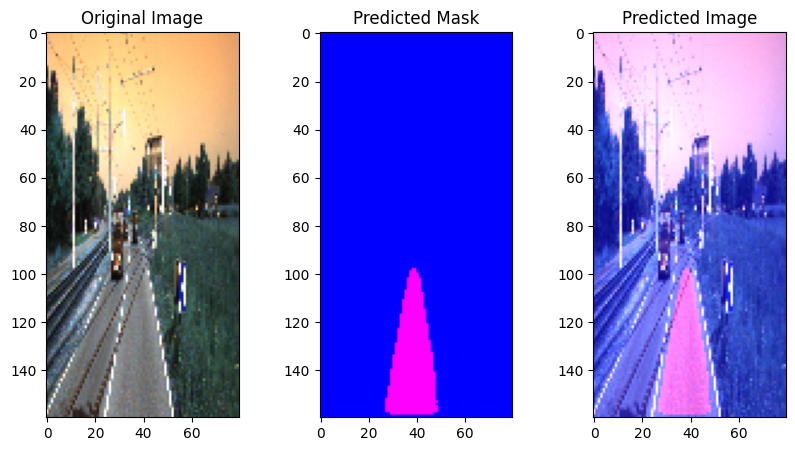

1/1 [==============================] - 0s 23ms/step


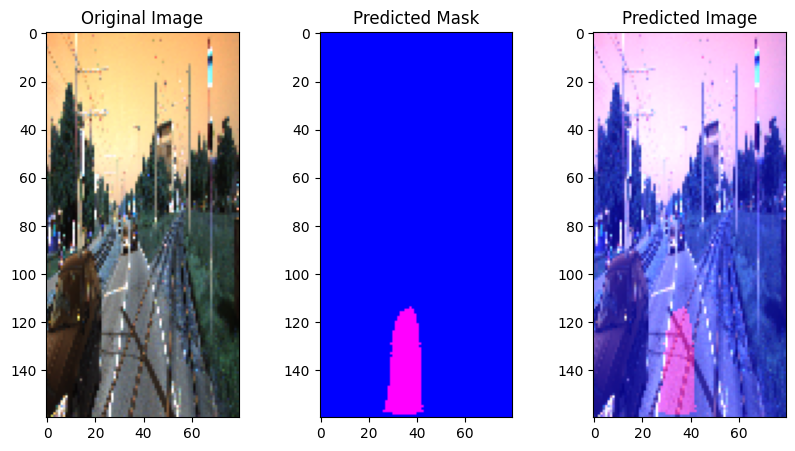

1/1 [==============================] - 0s 37ms/step


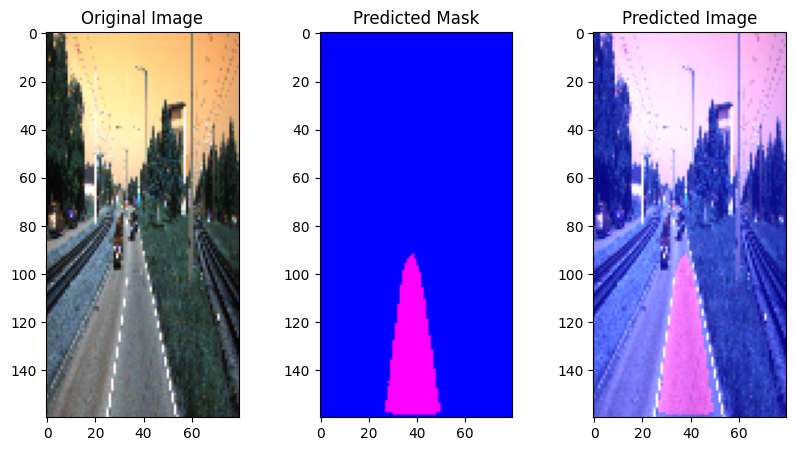

1/1 [==============================] - 0s 27ms/step


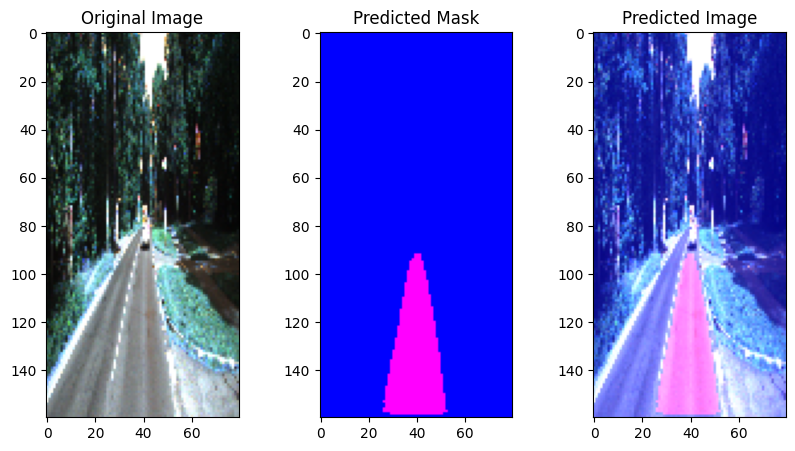

1/1 [==============================] - 0s 25ms/step


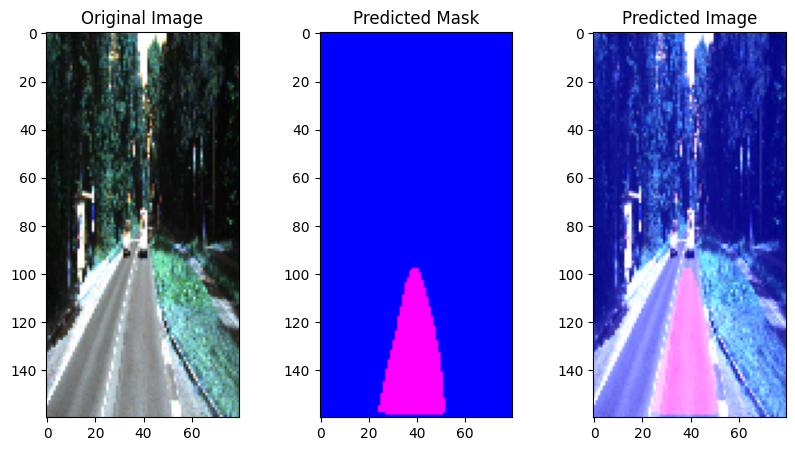

1/1 [==============================] - 0s 27ms/step


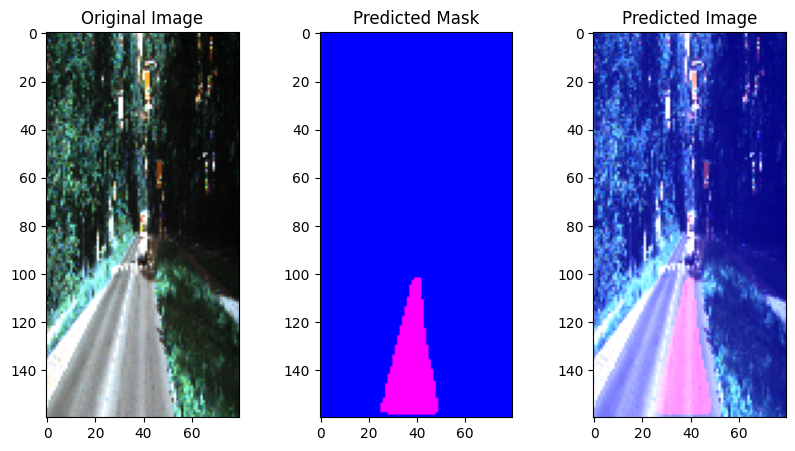

1/1 [==============================] - 0s 29ms/step


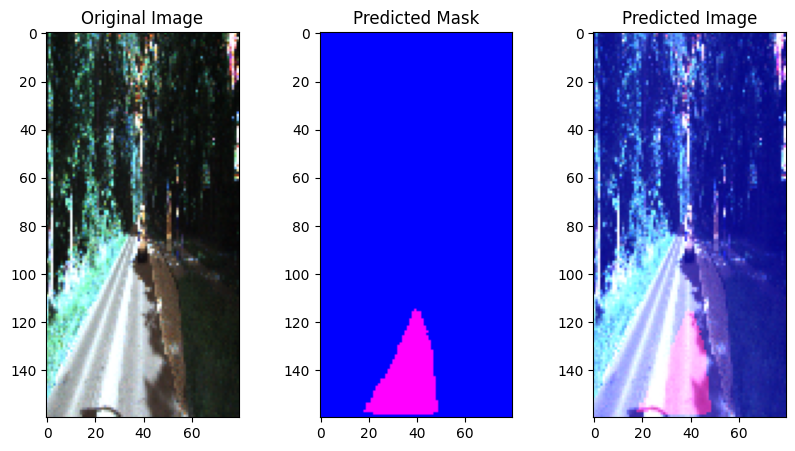

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_val is a list or array containing image data
# Modify this according to the actual structure of your data

# Function to preprocess and predict using the model
def predict_and_show(image_data, model):
    # Preprocess the image data
    test_array = np.array(image_data)

    # Predict using the model
    yhat = model.predict(np.expand_dims(test_array, 0))
    yhat = np.round(yhat.squeeze())  # Remove singleton dimensions and round to 0 or 1

    # Create a mask image using PIL
    mask_array = (yhat * 255).astype(np.uint8)
    mask_img = Image.fromarray(mask_array)

    # overlaying mask on the original image
    ground_truth_mask = cv2.resize(mask_array, (image_data.shape[1], image_data.shape[0]))
    result_image = cv2.addWeighted(image_data, 1, ground_truth_mask, 0.5, 0)


    # Display the original image and predicted mask side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image_data)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_img, cmap='gray')  # Specify the colormap if it's a grayscale image
    plt.title("Predicted Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(result_image)  # Specify the colormap if it's a grayscale image
    plt.title("Predicted Image")


    plt.show()

# Assuming X_val contains the image data for validation
for i in range(10):
    image_data = test_images[i]
    predict_and_show(image_data, model)


In [ ]:
video_path = "/content/sample_data/MyDrive/MyDrive/lane_detection/testing/VID-20231114-WA0004.mp4"
cap = cv2.VideoCapture(video_path)

# Define the codec using VideoWriter_fourcc() and create a VideoWriter object
# bing code
import time

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create VideoWriter object to save the output video
output_video_path = '/content/sample_data/MyDrive/MyDrive/lane_detection/output/output7.mp4'
fourcc = cv2.VideoWriter_fourcc(*'MP4V')  # You can choose other codecs as well
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Process each frame in the video
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Resize the frame to the desired input size of the model
    resized_frame = cv2.resize(frame, (224, 224))

    # Predict using the model
    pred = model.predict(np.expand_dims(resized_frame, 0))
    pred = np.round(pred.squeeze())
    mask_img = (pred * 255).astype(np.uint8)

    # Resize the mask to match the original frame dimensions
    ground_truth_mask = cv2.resize(mask_img, (width, height))

    # Apply the mask to the original frame to highlight the lane region
    result_frame = cv2.addWeighted(frame, 1, ground_truth_mask, 0.5, 0)

    # Display the result (optional)
    #out.write( result_frame)

    # Write the frame to the output video file
    out.write(result_frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and writer objects
cap.release()
out.release()
cv2.destroyAllWindows()



1/1 [==============================] - 0s 20ms/step


# **6.LANE-NET**

In [16]:
# LANE-NET
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Activation, Concatenate, Dropout, Dense, Flatten

def lane_net(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), padding='same', activation='relu')(pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), padding='same', activation='relu')(pool3)
    pool4 = MaxPooling2D((2, 2))(conv4)

    # Decoder
    up1 = UpSampling2D((2, 2))(pool4)
    concat1 = Concatenate()([up1, conv4])
    conv5 = Conv2D(512, (3, 3), padding='same', activation='relu')(concat1)

    up2 = UpSampling2D((2, 2))(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = Conv2D(256, (3, 3), padding='same', activation='relu')(concat2)

    up3 = UpSampling2D((2, 2))(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = Conv2D(128, (3, 3), padding='same', activation='relu')(concat3)

    up4 = UpSampling2D((2, 2))(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = Conv2D(64, (3, 3), padding='same', activation='relu')(concat4)

    # Segmentation output
    seg_output = Conv2D(3, (1, 1), activation='sigmoid', name='seg_output')(conv8)

    # Binary classification output
    flat = Flatten()(pool4)
    dense1 = Dense(256, activation='relu')(flat)
    drop = Dropout(0.5)(dense1)
    binary_output = Dense(1, activation='sigmoid', name='binary_output')(drop)

    model = Model(inputs=inputs, outputs=[seg_output])
    return model

#input_shape = (80, 160, 3)
model = lane_net(input_shape)

# Compile the model
model.compile(optimizer='adam',
              loss={'seg_output': 'binary_crossentropy'},
              metrics={'seg_output': 'accuracy'})

# Summary of the model
model.summary()

# Example of how to train the model
# history = model.fit(X_train, [Y_train_seg, Y_train_binary], epochs=epochs, validation_data=(X_val, [Y_val_seg, Y_val_binary]), batch_size=batch_size)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 160, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 80, 160, 64)          1792      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 40, 80, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 40, 80, 128)          73856     ['max_pooling2d[0][0]']   

In [ ]:
history = model.fit(X_train,Y_train, epochs=epochs, validation_data=(X_val, Y_val), batch_size=batch_size)

Epoch 1/30
3/3 [==============================] - 206s 64s/step - loss: 25.5752 - accuracy: 0.7526 - val_loss: 4.8701 - val_accuracy: 0.8848
Epoch 2/30
3/3 [==============================] - 193s 61s/step - loss: 3.4101 - accuracy: 0.8839 - val_loss: 1.2375 - val_accuracy: 0.8848
Epoch 3/30
3/3 [==============================] - 192s 63s/step - loss: 1.3176 - accuracy: 0.8839 - val_loss: 0.7046 - val_accuracy: 0.8848
Epoch 4/30
3/3 [==============================] - 205s 69s/step - loss: 0.8395 - accuracy: 0.8839 - val_loss: 1.0267 - val_accuracy: 0.8848
Epoch 5/30
3/3 [==============================] - 191s 61s/step - loss: 1.0720 - accuracy: 0.8839 - val_loss: 0.8771 - val_accuracy: 0.8848
Epoch 6/30
3/3 [==============================] - 194s 62s/step - loss: 0.8636 - accuracy: 0.8839 - val_loss: 0.5142 - val_accuracy: 0.8848
Epoch 7/30
3/3 [==============================] - 192s 62s/step - loss: 0.5671 - accuracy: 0.8839 - val_loss: 0.3056 - val_accuracy: 0.8848
Epoch 8/30
3/3 [===

In [18]:
preds = model.predict(X_val)
preds.max(), preds.min()

1/1 [==============================] - 0s 223ms/step


(1.0, 0.0)

In [19]:
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recal = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])


# accuracy
accuracy.update_state(Y_val, preds)
accuracy_value = accuracy.result().numpy()
# precision
precision.update_state(Y_val, preds)
precision_value = precision.result().numpy()
# recal
recal.update_state(Y_val, preds)
recal_value = recal.result().numpy()
# f1 score
f1_score = 2 / ((1 / precision_value) + (1 / recal_value))

# Intersection over union (IoU)
iou.update_state(Y_val, preds)
iou_value = iou.result().numpy()

print("Accuracy:", accuracy_value)
print("Precision:", precision_value)
print("Recal:", recal_value)
print('F1 Score: ', f1_score)
print('IoU: ', iou_value)

Accuracy: 0.14117448
Precision: 0.98609155
Recal: 0.94179624
F1 Score:  0.963435032296446
IoU:  0.20794746


1/1 [==============================] - 0s 19ms/step


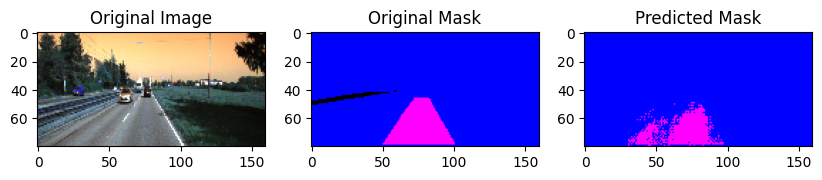

1/1 [==============================] - 0s 18ms/step


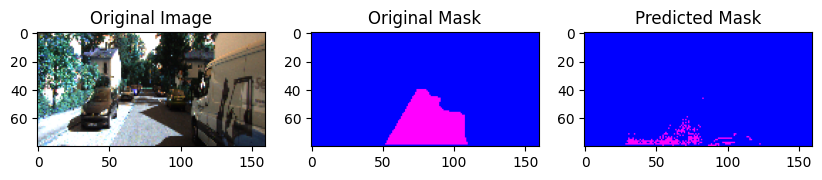

1/1 [==============================] - 0s 18ms/step


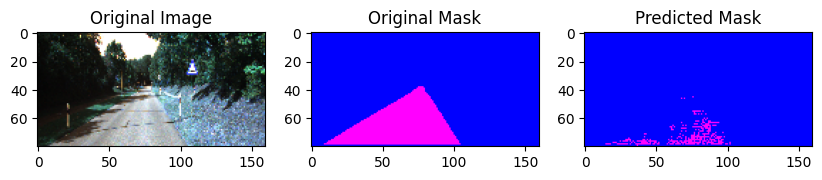

1/1 [==============================] - 0s 18ms/step


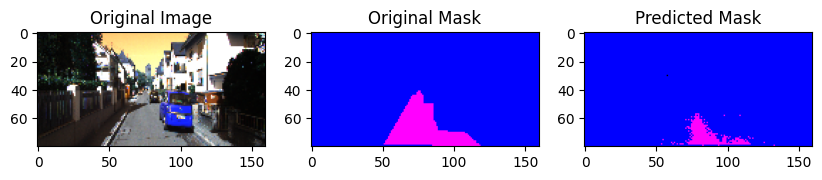

1/1 [==============================] - 0s 18ms/step


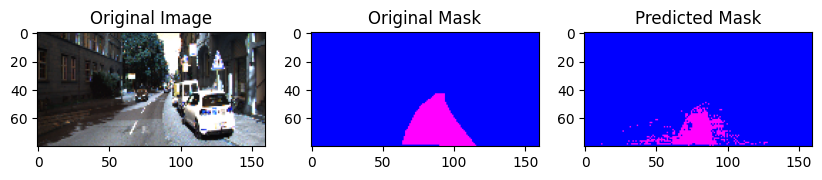

1/1 [==============================] - 0s 19ms/step


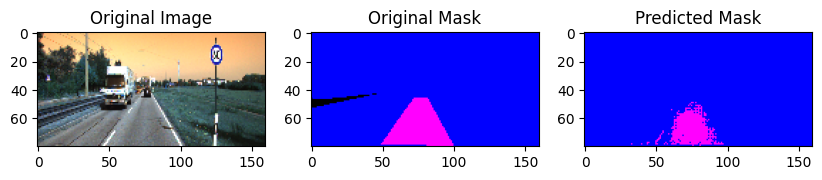

1/1 [==============================] - 0s 19ms/step


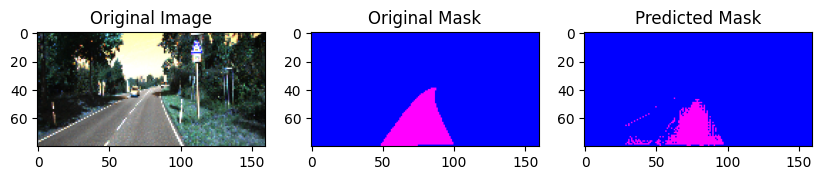

1/1 [==============================] - 0s 18ms/step


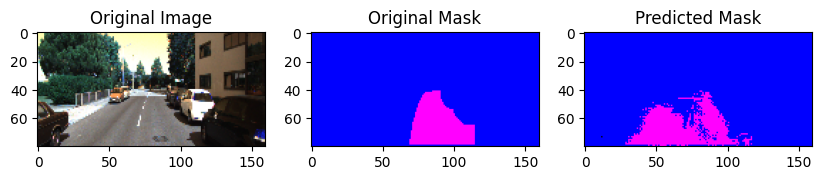

1/1 [==============================] - 0s 17ms/step


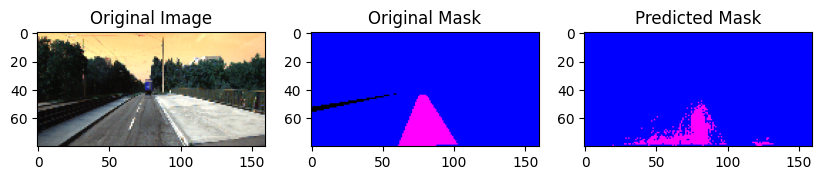

1/1 [==============================] - 0s 17ms/step


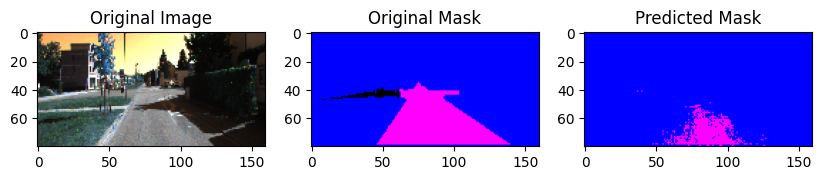

In [21]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_val is a list or array containing image data
# Modify this according to the actual structure of your data

# Function to preprocess and predict using the model
def predict_and_show(image_data, original_mask, model):
    # Preprocess the image data
    test_array = np.array(image_data)

    # Predict using the model
    yhat = model.predict(np.expand_dims(test_array, 0))
    yhat = np.round(yhat.squeeze())  # Remove singleton dimensions and round to 0 or 1

    # Create a mask image using PIL
    mask_image = Image.fromarray((yhat * 255).astype(np.uint8))

    # Display the original image and predicted mask side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image_data)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(original_mask*255)
    plt.title("Original Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(np.array(yhat*255).astype(np.uint8))  # Specify the colormap if it's a grayscale image
    plt.title("Predicted Mask")

    plt.show()

# Assuming X_val contains the image data for validation
for i in range(10):
    image_data = X_val[i]
    original_mask = Y_val[i]
    predict_and_show(image_data,original_mask, model)


In [22]:
# testing on test data
test_dir = "/content/sample_data/MyDrive/MyDrive/lane_detection/data_road/testing/image_2"
import os
import re

def alphanumeric_key(s):
    # Split the string into a list of strings and numbers
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]


test_images = []

# Load images
image_files = sorted([file for file in os.listdir(test_dir) if file.endswith('.png')], key=alphanumeric_key)
for image_file in image_files:
    image_path = os.path.join(test_dir, image_file)
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (80,160))  # Specify the desired dimensions
    test_images.append(resized_image)


# Convert lists to NumPy arrays
test_images = np.array(test_images)

# Print the shapes of the arrays
print("test_images shape:", test_images.shape)

test_images shape: (290, 160, 80, 3)


1/1 [==============================] - 1s 953ms/step


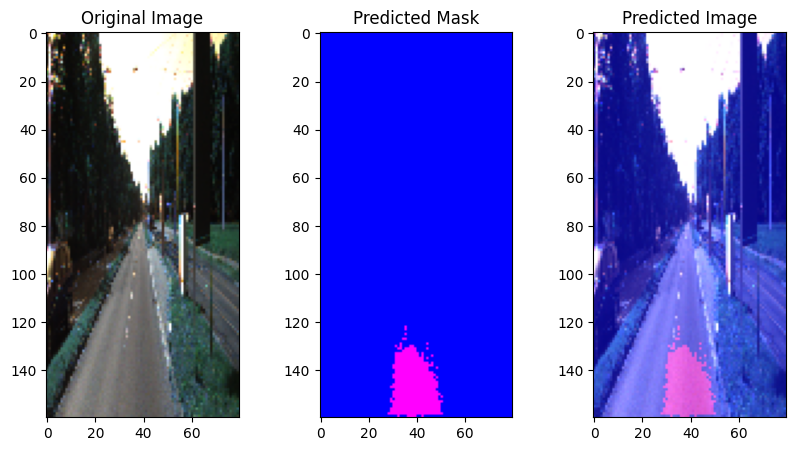

1/1 [==============================] - 0s 18ms/step


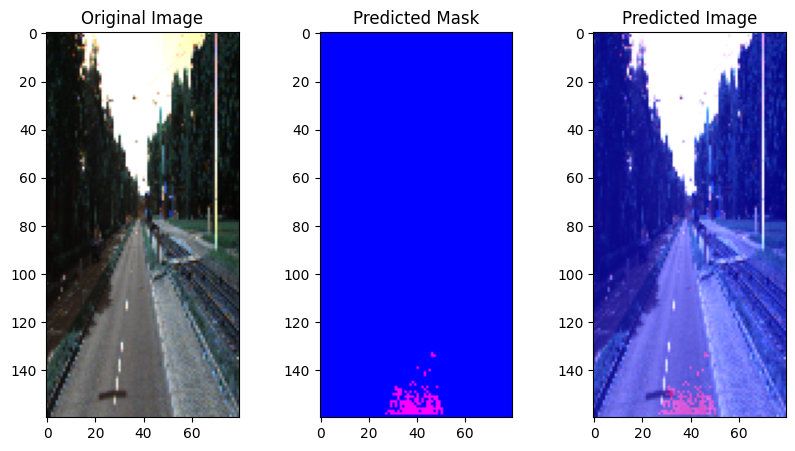

1/1 [==============================] - 0s 17ms/step


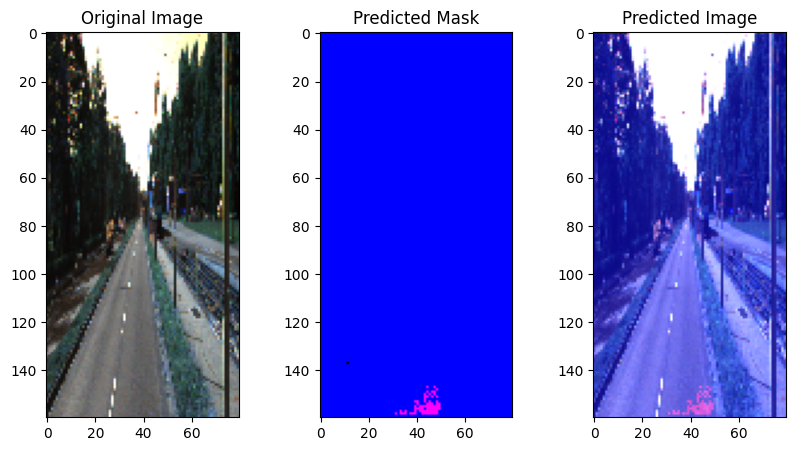

1/1 [==============================] - 0s 22ms/step


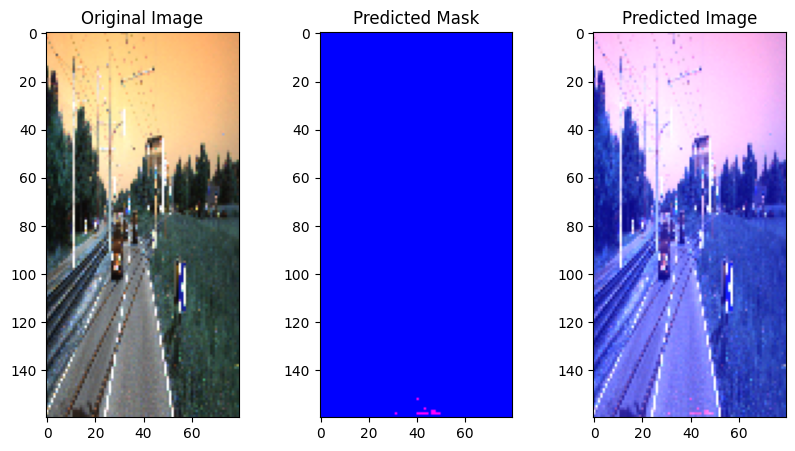

1/1 [==============================] - 0s 24ms/step


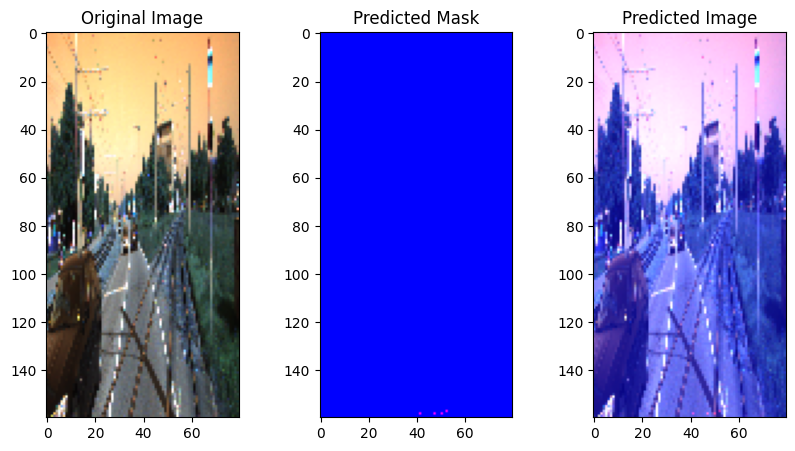

1/1 [==============================] - 0s 23ms/step


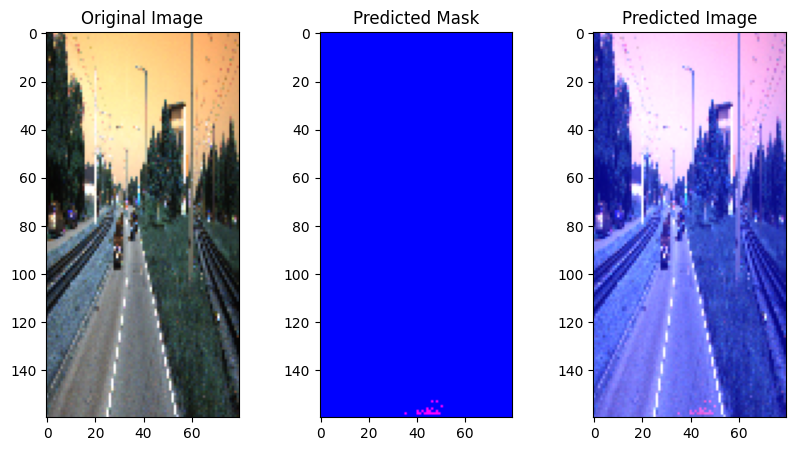

1/1 [==============================] - 0s 25ms/step


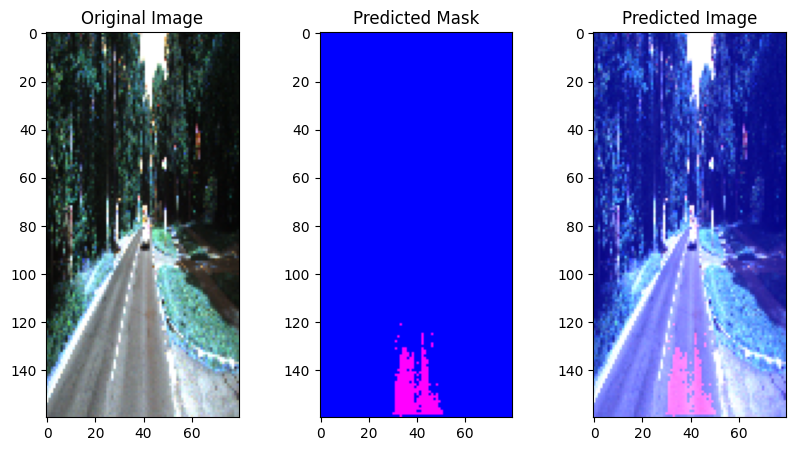

1/1 [==============================] - 0s 28ms/step


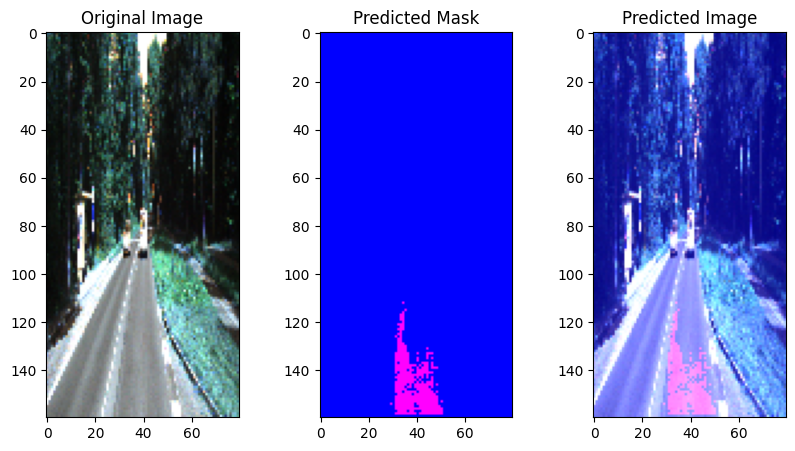

1/1 [==============================] - 0s 27ms/step


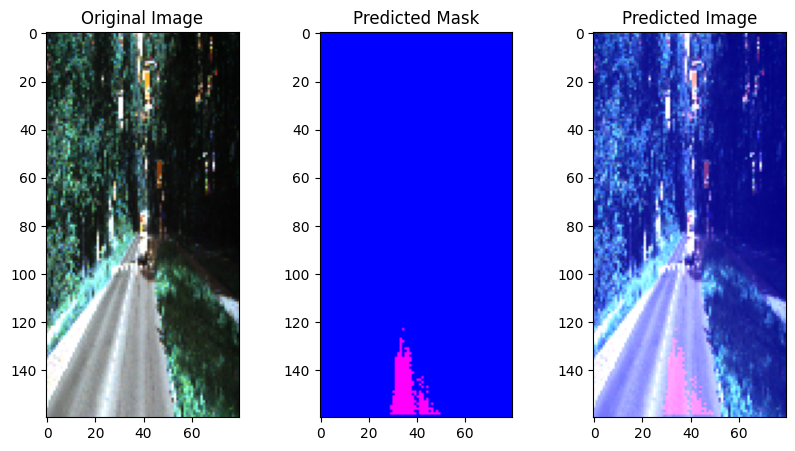

1/1 [==============================] - 0s 28ms/step


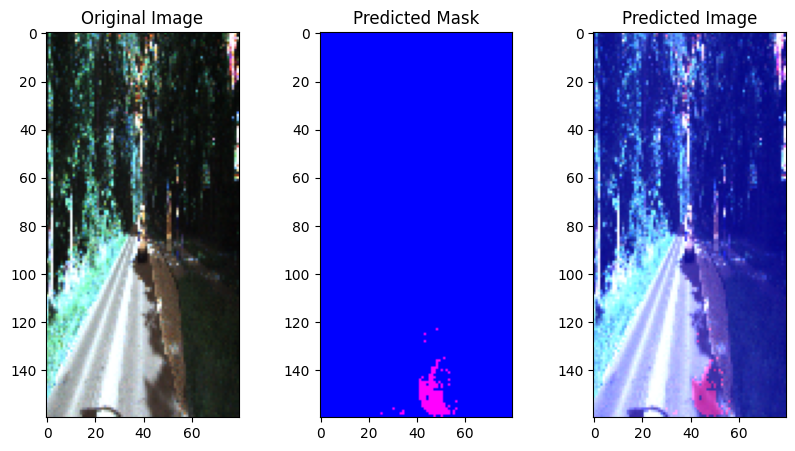

In [23]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_val is a list or array containing image data
# Modify this according to the actual structure of your data

# Function to preprocess and predict using the model
def predict_and_show(image_data, model):
    # Preprocess the image data
    test_array = np.array(image_data)

    # Predict using the model
    yhat = model.predict(np.expand_dims(test_array, 0))
    yhat = np.round(yhat.squeeze())  # Remove singleton dimensions and round to 0 or 1

    # Create a mask image using PIL
    mask_array = (yhat * 255).astype(np.uint8)
    mask_img = Image.fromarray(mask_array)

    # overlaying mask on the original image
    ground_truth_mask = cv2.resize(mask_array, (image_data.shape[1], image_data.shape[0]))
    result_image = cv2.addWeighted(image_data, 1, ground_truth_mask, 0.5, 0)


    # Display the original image and predicted mask side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image_data)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_img, cmap='gray')  # Specify the colormap if it's a grayscale image
    plt.title("Predicted Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(result_image)  # Specify the colormap if it's a grayscale image
    plt.title("Predicted Image")


    plt.show()

# Assuming X_val contains the image data for validation
for i in range(10):
    image_data = test_images[i]
    predict_and_show(image_data, model)
